In [1]:
import os 
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### node classification with GNNs

1. Inductive learning: model is trained on a training set and tested on a separate test set 
2. Transductive learning: makes predictions on test instances that are from the same distribution as the training data but are not included in the training set itself 

what are pre-transform vs transform?

- transform: applied to a Data object each time it is accessed from a dataset. 
- pre-transform: applied to a Data object before it is saved to disk.

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='../datasets/cora', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}')
print('===========')
print(f'# graphs: {len(dataset)}')
print(f'# features: {dataset.num_features}')
print(f'# classes: {dataset.num_classes}')



Dataset: Cora()
# graphs: 1
# features: 1433
# classes: 7


In [3]:
# dir(data) # to check available attributes and methods for data object

In [4]:
data = dataset[0]

print()
print(data)
print('=========')

# gather info
print(f'# nodes: {data.num_nodes}')
print(f'# edges: {data.num_edges}')
print(f'avg node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'# training nodes: {data.train_mask.sum()}')
print(f'training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'has isolated nodes: {data.has_isolated_nodes()}')
print(f'has self-loops: {data.has_self_loops()}')
print(f'is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
# nodes: 2708
# edges: 10556
avg node degree: 3.90
# training nodes: 140
training node label rate: 0.05
has isolated nodes: False
has self-loops: False
is undirected: True


In [5]:
# dir(data)

In [6]:
# # check how to use NormalizeFeatures class

# from torch_geometric.data import Data

# norm = NormalizeFeatures()
# temp = torch.randint(1,10,size=(3,4), dtype=float)

# temp_data = Data(x=temp)
# norm_data = norm(temp_data)

# print(temp)
# print(norm_data.x[0,:].sum())
# print(norm_data.x[1,:].sum())
# print(norm_data.x[2,:].sum())

### build an MLP

In [7]:
print(data)
print(f'# train nodes: {data.train_mask.sum()}')
print(f'# valid nodes: {data.val_mask.sum()}')
print(f'# test nodes: {data.test_mask.sum()}')
# trained on 140 nodes and predicted for 1000 test nodes ==> causing overfitting!

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
# train nodes: 140
# valid nodes: 500
# test nodes: 1000


In MLP, using only the node features and not connectivity/edge features, resulting in poor accuracy or not using citation information to classify the relevant documents together

In [8]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.ln1 = Linear(dataset.num_features, hidden_channels)
        self.ln2 = Linear(hidden_channels, dataset.num_classes)
    
    def forward(self,x):
        x = self.ln1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.ln2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = (pred[data.test_mask] == data.y[data.test_mask])
    test_acc = int(test_correct.sum())/int(data.test_mask.sum())
    return test_acc

for epoch in range(1,201):
    loss = train()
    # if epoch % 10 == 0:
    #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

MLP(
  (ln1): Linear(in_features=1433, out_features=16, bias=True)
  (ln2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.41

In [9]:
test_acc = test()
print(f'Test acc: {test_acc:.4f}')

Test acc: 0.5900


### train a GNN model: GCNConv

1. MLP does not make use of neighboring node information

In [10]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [11]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

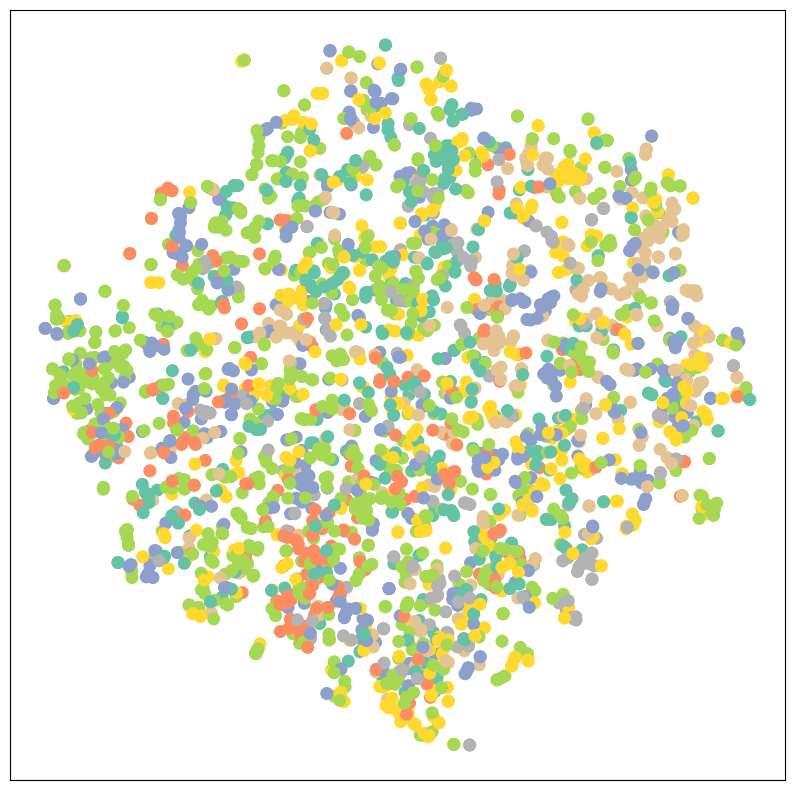

In [12]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [13]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9506
Epoch: 002, Loss: 1.9434
Epoch: 003, Loss: 1.9432
Epoch: 004, Loss: 1.9283
Epoch: 005, Loss: 1.9208
Epoch: 006, Loss: 1.9168
Epoch: 007, Loss: 1.9040
Epoch: 008, Loss: 1.9044
Epoch: 009, Loss: 1.8883
Epoch: 010, Loss: 1.8860
Epoch: 011, Loss: 1.8731
Epoch: 012, Loss: 1.8700
Epoch: 013, Loss: 1.8515
Epoch: 014, Loss: 1.8489
Epoch: 015, Loss: 1.8393
Epoch: 016, Loss: 1.8235
Epoch: 017, Loss: 1.8194
Epoch: 018, Loss: 1.8090
Epoch: 019, Loss: 1.7896
Epoch: 020, Loss: 1.7739
Epoch: 021, Loss: 1.7626
Epoch: 022, Loss: 1.7671
Epoch: 023, Loss: 1.7693
Epoch: 024, Loss: 1.7555
Epoch: 025, Loss: 1.7161
Epoch: 026, Loss: 1.7276
Epoch: 027, Loss: 1.7248
Epoch: 028, Loss: 1.6866
Epoch: 029, Loss: 1.6691
Epoch: 030, Loss: 1.6864
Epoch: 031, Loss: 1.6521
Epoch: 032, Loss: 1.6647
Epoch: 033, Loss: 1.6330
Epoch: 034, Loss: 1.6268
Epoch: 035, Loss: 1.5888
Epoch: 036, Loss: 1.5643
Epoch: 037, Loss: 1.5596
Epoch: 038, Loss: 1.5611
Epoch: 039, Loss: 1.5453
Epoch: 040, Loss: 1.5480


In [14]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7960


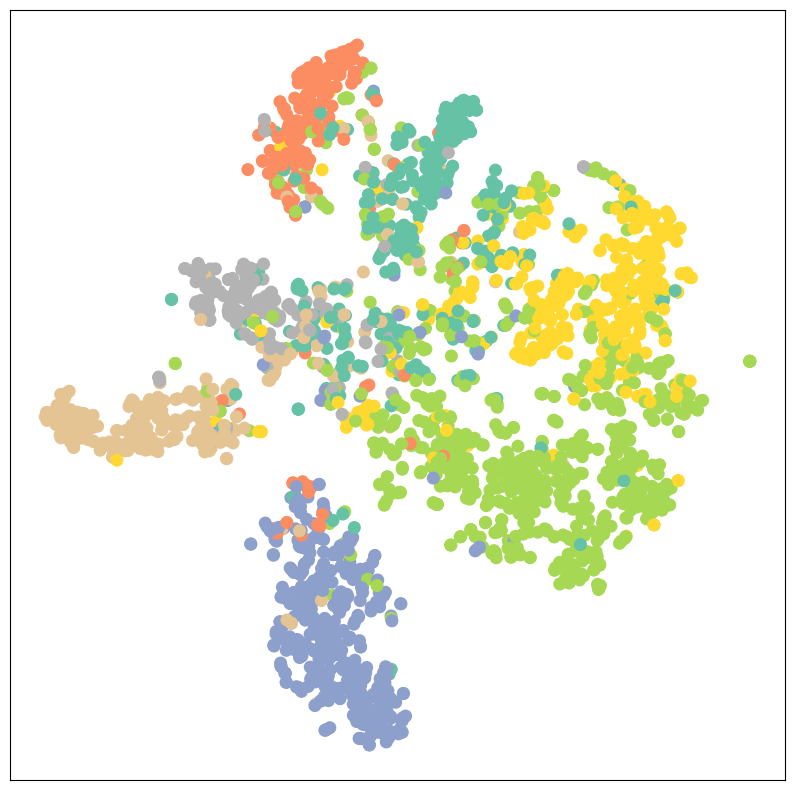

In [15]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### implement GAT model

In [16]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features,hidden_channels,heads=heads,dropout=0.6)  # TODO
        self.conv2 = GATConv(hidden_channels*heads,dataset.num_classes,concat=False,dropout=0.6)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9443, Val: 0.1280, Test: 0.1510
Epoch: 002, Loss: 2.0103, Val: 0.0920, Test: 0.1050
Epoch: 003, Loss: 1.9345, Val: 0.0760, Test: 0.0870
Epoch: 004, Loss: 1.9356, Val: 0.0780, Test: 0.0840
Epoch: 005, Loss: 1.9265, Val: 0.0780, Test: 0.0990
Epoch: 006, Loss: 1.9473, Val: 0.1380, Test: 0.1900
Epoch: 007, Loss: 1.9186, Val: 0.2680, Test: 0.3280
Epoch: 008, Loss: 1.9112, Val: 0.3720, Test: 0.4180
Epoch: 009, Loss: 1.9094, Val: 0.3880, Test: 0.4690
Epoch: 010, Loss: 1.9074, Val: 0.4360, Test: 0.4790
Epoch: 011, Loss: 1.9021, Val: 0.4480, Test: 0.4760
Epoch: 012, Loss: 1.8936, Val: 0.4640, Test: 0.4930
Epoch: 013, Loss: 1.8964, Val: 0.4940, Test: 0.5040
Epoch: 014, Loss: 1.8702, Val: 0.5040, Test: 0.5250
Epoch: 015, Loss: 2.3279, Val: 0.5460, Test: 0.5490
Epoch: 016, Loss: 1.8780, Val: 0.5460, Test: 0.5600
Epoch: 017, Loss: 1.8924, Val: 0.5840, Test: 0.5890
Epoch: 018, Loss: 1.8745, Val: 0.5920

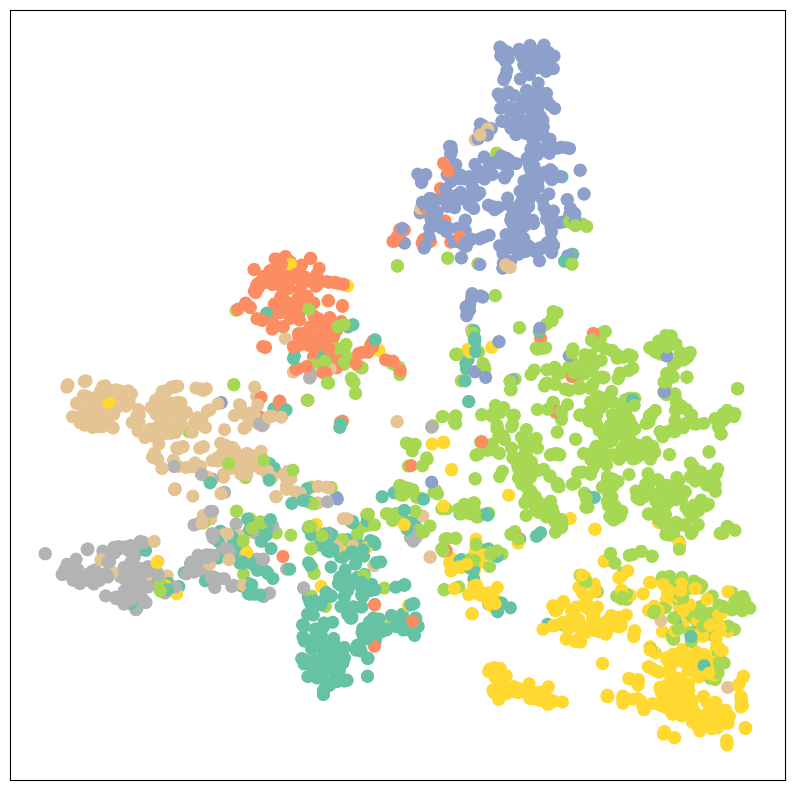

In [17]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)